Getting the necessary imports

In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.0.1
0.15.2


Downloading code for reusability

In [2]:
from going_modular.going_modular import data_setup, engine

c:\Users\adars\miniconda3\envs\midlar\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [4]:
# Setup Device Agnotic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
device

'cuda'

## 1. Get Data

In [6]:
import os
from pathlib import Path
import zipfile
import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.exists():
    print(f"[INFO] {image_path} already exists. Skipping Download")
else:
    print(f"[INFO] {image_path} not found. Downloading...")
    image_path.mkdir(parents=True, exist_ok="True")

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("[INFO] Downloading Data...")
        f.write(request.content)
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print(f"[INFO] Unzipping data")
        zip_ref.extractall(image_path)
if (data_path / "pizza_steak_sushi.zip").exists():
    os.remove(data_path / "pizza_steak_sushi.zip")

[INFO] data\pizza_steak_sushi already exists. Skipping Download


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Dataloaders for our model

### 2.1 Manual Transforms

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [9]:
from going_modular.going_modular.data_setup import create_dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=manual_transforms,
                                                                    batch_size=32)

In [10]:
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d031fceb90>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating Auto Transforms

In [11]:
weights  = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
auto_transforms = weights.transforms()

In [13]:
from going_modular.going_modular.data_setup import create_dataloaders
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                    test_dir=test_dir,
                                                                    transform=auto_transforms,
                                                                    batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1d031fdb010>,
 ['pizza', 'steak', 'sushi'])

## Setting up a pretrained model

### 3.1 Creating a effnetb0 model

In [14]:
# OLD way
# model = torchvision.models.efficientnet_b0(pretrained=True)

# NEW way
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [15]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [16]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [17]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [18]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.2 Viewing a summary of our model

In [19]:
from torchinfo import summary

summary(model=model,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.3 Freezing the layers and updating the classifier head

In [20]:
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [21]:
# Update the classifier head
from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [22]:
summary(model=model,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.4 Training our model

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [24]:
from going_modular.going_modular import engine

from timeit import default_timer as timer
start = timer()
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end = timer()
print(f"[INFO] Total training time: {end - start:.3f} seconds.")

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:22<01:28, 22.04s/it]

Epoch: 1 | train_loss: 1.0173 | train_acc: 0.5430 | test_loss: 0.7967 | test_acc: 0.8551


 40%|████      | 2/5 [00:39<00:58, 19.53s/it]

Epoch: 2 | train_loss: 0.8370 | train_acc: 0.7461 | test_loss: 0.6829 | test_acc: 0.8854


 60%|██████    | 3/5 [00:58<00:37, 18.94s/it]

Epoch: 3 | train_loss: 0.7769 | train_acc: 0.6914 | test_loss: 0.6184 | test_acc: 0.8958


 80%|████████  | 4/5 [01:16<00:18, 18.60s/it]

Epoch: 4 | train_loss: 0.6602 | train_acc: 0.7852 | test_loss: 0.6496 | test_acc: 0.8561


100%|██████████| 5/5 [01:34<00:00, 18.81s/it]

Epoch: 5 | train_loss: 0.6013 | train_acc: 0.8242 | test_loss: 0.5765 | test_acc: 0.8759
[INFO] Total training time: 94.059 seconds.


## 4. Evaluating our model

In [25]:
try:
    from helper_functions import plot_loss_curves
except:
    print(f"[INFO] helper_functions.py not found. Downloading...")
    import requests
    with open("helper_functions.py", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

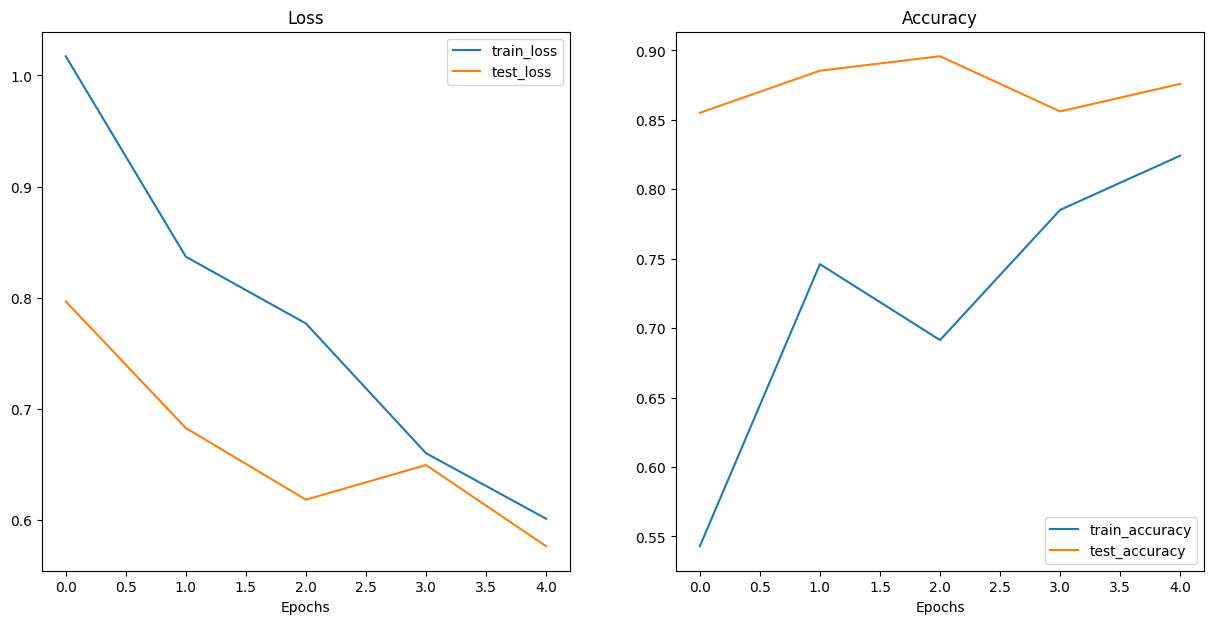

In [26]:
plot_loss_curves(results)

## 5. Make predictions using our model

In [27]:
# Create a function to make predictions
from PIL import Image
def pred_plot(model,
              image_path,
              class_names,
              image_size=(224, 224),
              transforms=None,
              device=device):
    img = Image.open(image_path)
    
    if transforms is not None:
        image_transforms = transforms
    else:
        image_transforms = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
    
    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_img = image_transforms(img).unsqueeze(dim=0).to(device)
        img_pred = model(transformed_img)
    
    img_pred_probs = torch.softmax(img_pred, dim=1)
    img_pred_label = torch.argmax(img_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted Class: {class_names[img_pred_label]} | Pred Prob: {img_pred_probs.max():.3f}")
    plt.axis(False)



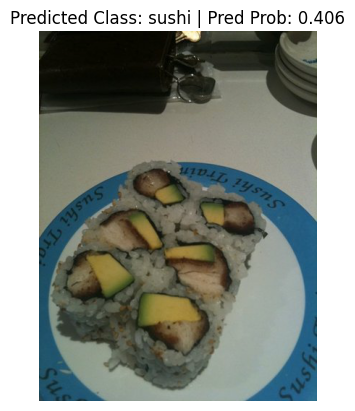

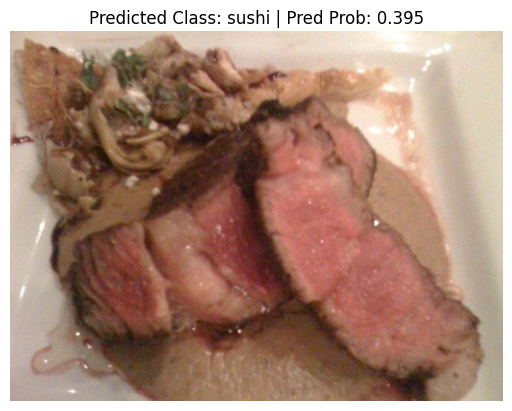

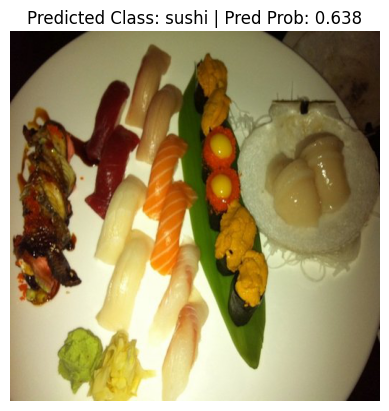

In [28]:
import random

n_imgs_plot = 3
img_path_list = list(Path(test_dir).glob("*/*.jpg"))
img_path_sample = random.sample(population=img_path_list,
                                k=n_imgs_plot)
for img_path in img_path_sample:
    pred_plot(model=model,
              image_path=img_path,
              class_names=class_names,
              image_size=(224, 224),
              transforms=auto_transforms,
              device=device)

### 5.1 Making predictions on custom data

In [29]:
data_path

WindowsPath('data')

In [30]:
import requests
custom_data_path = data_path / "pizza-dad.jpg"

if custom_data_path.exists():
    print("[INFO] Image already exists. Skipping Download...")
else:
    print("[INFO] Downloading data...")
    with open(custom_data_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        f.write(request.content)

[INFO] Image already exists. Skipping Download...


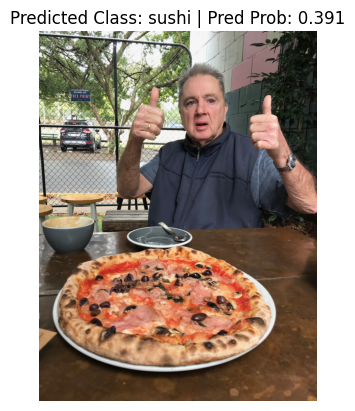

In [31]:
pred_plot(model=model,
              image_path=custom_data_path,
              class_names=class_names,
              image_size=(224, 224),
              transforms=auto_transforms,
              device=device)